In [1]:
from PIL import Image

# LZW encoding

## Encoding text

In [2]:
class LZWTxt:
    def __init__(self):
        # set of allowed characters, every disallowed character "c" is transformed to "*ord(c)"
        # e.g. "ę" -> "*281"
        self.atomic_chars = set([chr(i) for i in range(128)])
        
    def _cast_to_bin(self, num: int, bits: int) -> str:
        assert num >= 0
        bin_string = str(bin(num))[2:] # get rid of leading "0b"
        return '0' * (bits-len(bin_string)) + bin_string # pad with 0s
        
    def encode(self, text: str, bits_per_symbol: int = 16) -> str:
        assert bits_per_symbol >= 7 # 7 bits are required for ASCII characters
        # calculate the maximum size of dictionary
        max_dict = 2 ** bits_per_symbol
        # store the codeword length at the beginning of the cipher
        cipher = [str(bits_per_symbol)+' ']
        # initialize dictionary with all possible bytes
        dic = {chr(i): self._cast_to_bin(i, bits_per_symbol) for i in range(128)}
        old = text[0]
        t_pos = 1
        
        while t_pos < len(text):
            new = text[t_pos]
            # Handle non ASCII characters
            if new not in self.atomic_chars:
                text = '*' + str(ord(new)) + text[t_pos+1:]
                t_pos = 0
                continue
            
            t_pos += 1
            
            if old+new in dic:
                old = old + new
            else:
                cipher.append(dic[old])
                if len(dic) < max_dict:
                    dic[old+new] = self._cast_to_bin(len(dic), bits_per_symbol)
                    
                old = new

        cipher.append(dic[old])
        return "".join(cipher)

    def decode(self, cipher: str) -> str:
        bits_per_symbol, cipher = cipher.split()
        bits_per_symbol = int(bits_per_symbol)
        # calculate the maximum size of dictionary
        max_dict = 2 ** bits_per_symbol
        
        dic = {self._cast_to_bin(i, bits_per_symbol): chr(i) for i in range(128)}
        
        old = dic[cipher[:bits_per_symbol]]
        msg = [old]
        t_pos = bits_per_symbol
        
        while t_pos < len(cipher):
            new = cipher[t_pos:t_pos+bits_per_symbol]
            t_pos += bits_per_symbol

            if new in dic:
                new = dic[new]
                if len(dic) < max_dict:
                    dic[self._cast_to_bin(len(dic), bits_per_symbol)] = old + new[0]
            else:
                new = old + old[0]
                if len(dic) < max_dict:
                    dic[self._cast_to_bin(len(dic), bits_per_symbol)] = new

            msg.append(new)
            old = new

        return "".join(msg)

In [3]:
lzw = LZWTxt()

### 1) Some short text examples

#### Modified lecture example

In [4]:
cipher = lzw.encode('BABAABAAAęęę', 8)
cipher

'8 0100001001000001100000001000000101000001100001000010101000110010001110000011000110000110100010001000101000110001'

In [5]:
lzw.decode(cipher)

'BABAABAAA*281*281*281'

#### Norm wiki example

In [6]:
norm_wiki_path = "lab6_lab7/norm_wiki_sample.txt"

In [7]:
with open(norm_wiki_path, 'r') as f:
    norm_wiki_text = f.read()

norm_wiki_text[:200]

' albert of prussia 17 may 1490 20 march 1568 was the last grand master of the teutonic knights who after converting to lutheranism became the first monarch of the duchy of prussia the secularized stat'

In [8]:
cipher = lzw.encode(norm_wiki_text[:200], 8)
cipher

'8 0010000001100001011011000110001001100101011100100111010000100000011011110110011000100000011100000111001001110101011100110111001101101001011000010010000000110001001101110010000001101101011000010111100110010010001101000011100100110000001000000011001010011100100101100111001001100011011010001001001000110101001101100011100000100000011101110110000101110011001000000111010001101000011001010010000001101100101010101000011001100111011100100110000101101110011001001001010110110010100001001000011110001001101011011010111101110100011001010111010101110100011011110110111001101001011000110010000001101011110001010110011101101000011101001010101101110111011010000110111110000000011001101100000001110010001000000110001111000100011101101000010001110100011010010110111001100111101011001101000101101100110000101010111010110101110001010111001101101101001000001000001101100011011000010110110110111111101011100010000001100110011010010111001001110011100001100110110111000100011000011010000110100011100010001010110011101

In [9]:
lzw.decode(cipher)

' albert of prussia 17 may 1490 20 march 1568 was the last grand master of the teutonic knights who after converting to lutheranism became the first monarch of the duchy of prussia the secularized stat'

In [10]:
assert norm_wiki_text[:200] == lzw.decode(cipher)

#### Wiki example

In [11]:
wiki_path = "lab6_lab7/wiki_sample.txt"

In [12]:
with open(wiki_path, 'r') as f:
    wiki_text = f.read()

wiki_text[:200]

'@@1514 Albert of Prussia ( 17 May 1490 20 March 1568 ) was the last Grand Master of the Teutonic Knights , who after converting to Lutheranism , became the first monarch of the Duchy of Prussia , the '

In [13]:
cipher = lzw.encode(wiki_text[:200], 8)
cipher

'8 0100000001000000001100010011010100110001001101000010000001000001011011000110001001100101011100100111010000100000011011110110011000100000010100000111001001110101011100110111001101101001011000010010000000101000001000000011000100110111001000000100110101100001011110011001101000110100001110010011000000100000001100101010010010011110011100100110001101101000100110100011010100110110001110000010000000101001001000000111011101100001011100110010000001110100011010000110010100100000011011001011010010001100010001110111001001100001011011100110010010011101101111001000101010001101100011111011011110111001010101000110010101110101011101000110111101101110011010010110001100100000010010111100111101100111011010000111010010110101001011001011001001101000011011110010000001100001011001100111010011000101011000111100111001110110100010100111010001101001011011100110011110110110110111000100110011001100101110001011111111001111011100110110110100100000110110011000100101100011011000010110110110111001110010000010000001100

In [14]:
lzw.decode(cipher)

'@@1514 Albert of Prussia ( 17 May 1490 20 March 1568 ) was the last Grand Master of the Teutonic Knights , who after converting to Lutheranism , became the first monarch of the Duchy of Prussia , the '

In [15]:
assert wiki_text[:200] == lzw.decode(cipher)

### 2) Experiments on whole wiki texts

#### Norm wiki

In [16]:
%%time
min_cipher = lzw.encode(norm_wiki_text, 7)

CPU times: user 1.75 s, sys: 22.4 ms, total: 1.77 s
Wall time: 1.78 s


In [17]:
assert norm_wiki_text == lzw.decode(min_cipher)

First let's find the codeword length for which the encoding is the shortest

In [18]:
bits = 8
while True:
    new_cipher = lzw.encode(norm_wiki_text, bits)
    if len(new_cipher) < len(min_cipher):
        min_cipher = new_cipher
    else:
        break

    bits += 1

print(f"Length of the shortest encoding: {len(min_cipher)}, length of codeword: {bits-1}")

Length of the shortest encoding: 32130103, length of codeword: 20


The best encoding is **~57% shorter** than naive encoding with ASCII codes in binary

In [19]:
len(min_cipher) / (7 * len(norm_wiki_text))

0.425437002045494

### Wiki

In [20]:
%%time
min_cipher = lzw.encode(wiki_text, 7)

CPU times: user 1.97 s, sys: 29.9 ms, total: 2 s
Wall time: 2.03 s


In [21]:
assert wiki_text == lzw.decode(min_cipher)

First let's find the codeword length for which the encoding is the shortest

In [22]:
bits = 8
while True:
    new_cipher = lzw.encode(wiki_text, bits)
    if len(new_cipher) < len(min_cipher):
        min_cipher = new_cipher
    else:
        break

    bits += 1

print(f"Length of the shortest encoding: {len(min_cipher)}, length of codeword: {bits-1}")

Length of the shortest encoding: 36907023, length of codeword: 20


The best encoding is **~51% shorter** than naive encoding with ASCII codes in binary

In [23]:
len(min_cipher) / (7 * len(norm_wiki_text))

0.4886885429388164

## Encoding an image

In [24]:
class LZWBin:
    def _format_bytes(self, num: int, num_bytes: int) -> str:
        assert num >= 0
        bits = 8 * num_bytes
        bin_string = str(bin(num))[2:] # get rid of leading "0b"
        bin_string = '0' * (bits-len(bin_string)) + bin_string # pad with 0s
        bytes_arr = []
        for i in range(num_bytes):
            bytes_arr.append(int(bin_string[i*8 : (i+1)*8], 2))

        return bytes_arr
        
    def encode(self, byte_code: bytes, bytes_per_symbol: int = 2) -> bytes:
        assert bytes_per_symbol > 0 and bytes_per_symbol < 256
        # calculate the maximum size of dictionary
        max_dict = 2 ** (bytes_per_symbol*8)
        # store the codeword length at the beginning of the cipher
        cipher = [bytes_per_symbol]
        # initialize dictionary with all possible bytes
        dic = {(i,): self._format_bytes(i, bytes_per_symbol) for i in range(256)}
        old = (byte_code[0],)
        b_pos = 1
        
        while b_pos < len(byte_code):
            new = (byte_code[b_pos],)
            b_pos += 1
            
            if old+new in dic:
                old = old + new
            else:
                cipher.extend(dic[old])
                if len(dic) < max_dict:
                    dic[old+new] = self._format_bytes(len(dic), bytes_per_symbol)
                    
                old = new

        cipher.extend(dic[old])
        return bytes(cipher)

    def decode(self, cipher: bytes) -> bytes:
        bytes_per_symbol = cipher[0]
        # calculate the maximum size of dictionary
        max_dict = 2 ** (bytes_per_symbol*8)
        
        dic = {tuple(self._format_bytes(i, bytes_per_symbol)): (i,) for i in range(256)}

        
        old = dic[tuple(cipher[1:1+bytes_per_symbol])]
        msg = list(old)
        b_pos = bytes_per_symbol + 1
        
        while b_pos < len(cipher):
            new = tuple(cipher[b_pos:b_pos+bytes_per_symbol])
            b_pos += bytes_per_symbol

            if new in dic:
                new = dic[new]
                if len(dic) < max_dict:
                    dic[tuple(self._format_bytes(len(dic), bytes_per_symbol))] = old + (new[0],)
            else:
                new = old + (old[0],)
                if len(dic) < max_dict:
                    dic[tuple(self._format_bytes(len(dic), bytes_per_symbol))] = new

            msg.extend(list(new))
            old = new

        return bytes(msg)

In [25]:
lzw = LZWBin()

In [26]:
img_path = "lab6_lab7/lena.bmp"

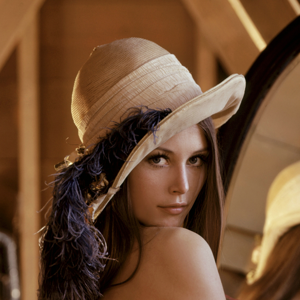

In [27]:
Image.open(img_path).resize((300, 300))

### 1) A short example

In [28]:
with open(img_path, 'rb') as f:
    img_data = f.read()

img_data[:200]

b"BMJ\xdb\xaf\x00\x00\x00\x00\x00\x8a\x00\x00\x00|\x00\x00\x00\xa8\x07\x00\x00\xa8\x07\x00\x00\x01\x00\x18\x00\x00\x00\x00\x00\xc0\xda\xaf\x00\x12\x0b\x00\x00\x12\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\x00\x00\xff\x00\x00\xff\x00\x00\x00\x00\x00\x00\xffBGRs\x80\xc2\xf5(`\xb8\x1e\x15 \x85\xeb\x01@33\x13\x80ff&@ff\x06\xa0\x99\x99\t<\n\xd7\x03$\\\x8f2\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\r$>\t :\x07\x1e8\n\x1f:\n 9\x05\x1b4\x04\x1a3\x05\x1b4\x06\x1b0\x06\x1b0\n\x1d2\n\x1d2\x05\x19+\x06\x1a,\x08\x19,\x05\x16)\x0b\x18(\x0b\x19+\t\x17)\x07\x15'\t\x17"

In [29]:
cipher = lzw.encode(img_data[:200])
cipher

b'\x02\x00B\x00M\x00J\x00\xdb\x00\xaf\x00\x00\x01\x05\x01\x05\x00\x8a\x01\x06\x00|\x01\x06\x00\xa8\x00\x07\x01\x05\x01\x0c\x01\x05\x00\x01\x00\x00\x00\x18\x01\x06\x01\x05\x00\xc0\x00\xda\x01\x04\x00\x12\x00\x0b\x01\x05\x01\x19\x01\x14\x01\x1d\x01\x06\x00\xff\x01\x05\x01 \x00\x00\x01"\x01\x14\x00\xff\x00B\x00G\x00R\x00s\x00\x80\x00\xc2\x00\xf5\x00(\x00`\x00\xb8\x00\x1e\x00\x15\x00 \x00\x85\x00\xeb\x00\x01\x00@\x003\x003\x00\x13\x00\x80\x00f\x00f\x00&\x00@\x01<\x00\x06\x00\xa0\x00\x99\x00\x99\x00\t\x00<\x00\n\x00\xd7\x00\x03\x00$\x00\\\x00\x8f\x002\x01\x1e\x01\x1e\x00\x04\x01N\x01Q\x00\r\x00$\x00>\x00\t\x00 \x00:\x00\x07\x00\x1e\x008\x00\n\x00\x1f\x00:\x00\n\x00 \x009\x00\x05\x00\x1b\x004\x00\x04\x00\x1a\x003\x01b\x004\x00\x06\x00\x1b\x000\x01j\x000\x00\n\x00\x1d\x002\x01o\x002\x00\x05\x00\x19\x00+\x00\x06\x00\x1a\x00,\x00\x08\x00\x19\x00,\x00\x05\x00\x16\x00)\x00\x0b\x00\x18\x00(\x00\x0b\x01u\x00\t\x00\x17\x00)\x00\x07\x00\x15\x00\'\x01\x85'

In [30]:
lzw.decode(cipher)

b"BMJ\xdb\xaf\x00\x00\x00\x00\x00\x8a\x00\x00\x00|\x00\x00\x00\xa8\x07\x00\x00\xa8\x07\x00\x00\x01\x00\x18\x00\x00\x00\x00\x00\xc0\xda\xaf\x00\x12\x0b\x00\x00\x12\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\x00\x00\xff\x00\x00\xff\x00\x00\x00\x00\x00\x00\xffBGRs\x80\xc2\xf5(`\xb8\x1e\x15 \x85\xeb\x01@33\x13\x80ff&@ff\x06\xa0\x99\x99\t<\n\xd7\x03$\\\x8f2\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\r$>\t :\x07\x1e8\n\x1f:\n 9\x05\x1b4\x04\x1a3\x05\x1b4\x06\x1b0\x06\x1b0\n\x1d2\n\x1d2\x05\x19+\x06\x1a,\x08\x19,\x05\x16)\x0b\x18(\x0b\x19+\t\x17)\x07\x15'\t\x17"

In [31]:
assert img_data[:200] == lzw.decode(cipher)

### 2) Experiments on whole image

In [32]:
%%time
min_cipher = lzw.encode(img_data)

CPU times: user 2.02 s, sys: 24 ms, total: 2.04 s
Wall time: 2.04 s


In [33]:
assert img_data == lzw.decode(min_cipher)

Let's find the codeword length for which the encoding is the shortest

In [34]:
num_bytes = 3
while True:
    new_cipher = lzw.encode(img_data, num_bytes)
    if len(new_cipher) < len(min_cipher):
        min_cipher = new_cipher
    else:
        break

    num_bytes += 1

print(f"Length of the shortest encoding: {len(min_cipher)}, length of codeword: {num_bytes-1}")

Length of the shortest encoding: 8051731, length of codeword: 3


For codeword length = 2, LZW encoding is **~1%** longer than the original image

In [36]:
len(lzw.encode(img_data)) / len(img_data)

1.0097422649909267

For codeword length = 3, LZW encoding is **~30%** shorter than the original image

In [37]:
len(lzw.encode(img_data, 3)) / len(img_data)

0.6986355154361785

 For codeword length = 4, LZW encoding is **~7%** shorter than the original image

In [38]:
len(lzw.encode(img_data, 4)) / len(img_data)

0.9315139916587838

For codeword length = 5, LZW encoding is **~16%** longer than the original image

In [39]:
len(lzw.encode(img_data, 5)) / len(img_data)

1.164392467881389